# Práctica de PySpark Machine Learning

## 1. Objetivo

Dado el siguente dataset:

https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv

Cuyas variables representan:

- **age**: edad del beneficiario principal
- **sex**: género del contratante del seguro, femenino, masculino
- **bmi**: índice de masa corporal, que proporciona una comprensión del cuerpo, de los pesos que son relativamente altos o bajos en relación con la altura, índice objetivo de peso corporal (kg / m ^ 2) utilizando la relación entre la altura y el peso, idealmente entre 18,5 y 24,9.
- **children**: número de hijos cubiertos por el seguro de salud / número de dependientes
- **smoker**: si fuma o no
- **region**: área de residencia del beneficiario en EE. UU., noreste, sureste, suroeste, noroeste.
- **charges**: costos médicos individuales facturados por el seguro de salud.


1. Utilizando la API de pandas de PySpark, realiza un EDA del dataset anterior.
2. Luego conviertelós a un DataFrame de Spark normal, realiza las conversiones necesarias para poder hacer machine learning (StringIndexer, StandardScaler, VectorAssembler...) y aplica un modelo de regresión lineal usando pyspark.ml

La variable objetivo a predecir sería **charges**.

## 2. Analytics

### 2.1. Load Libraries

In [1]:
# Install pyspark
!pip install pyspark

!apt-get install openjdk-8-jdk-headless -qq > /dev/null

import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

  Using cached pyspark-3.5.1.tar.gz (317.0 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=13ea20e2138d71df9c6e08e68c591fa63873c550ceebd2d92ec3657ab91ce9c9
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
# Import libraries for EDA
%matplotlib inline
import pyspark.pandas as ps
import pandas as pd
from pyspark.sql import SparkSession
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Preprocessing
from sklearn.preprocessing import OneHotEncoder
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Modeling
from pyspark.ml.regression import LinearRegression

# Performance Metrics
from pyspark.ml.evaluation import RegressionEvaluator

# Tunning
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


### 2.2. Load the data

In [3]:
# Initialize Spark session
spark = SparkSession.builder.appName("InsuranceLogisticRegression").getOrCreate()

#Import the data
df = ps.read_csv("insurance.csv", sep=",")
df.head(10)

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


### 2.3. Data Quality

Data Quality Analysis phase, ensuring the integrity and usability of data is crucial. Here are the steps that I will follow to check the data quality:

1. Check for Missing Values (Null Data)
* Identify Missing Values: Use functions like isnull() or isna() in pandas to identify missing values.
* Quantify Missing Values: Determine the percentage of missing values in each column to understand the extent of the issue.
* Handle Missing Values: Decide on a strategy to handle missing values, such as: remove or impute missing data.

2. Check for Duplicate Data

* Identify Duplicates: Use functions like duplicated() to find duplicate rows.
* Remove Duplicates: Remove duplicates using drop_duplicates().

3. Check for Inconsistent Data

* Consistency Checks: Ensure that categorical data values are consistent. For example, check for variations in the category names("USA" vs "U.S.A" vs "United States")
* Standardization: Standardize categorical variables to a consistent format.

4. Check for Outliers
* Identify Outliers: Use visualizations (box plots, scatter plots) and statistical methods (Z-score, IQR) to detect outliers.
* Handle Outliers: Decide whether to remove, transform, or keep outliers based on their impact on the analysis.

#### 2.3.1. Check for Null Data

In [4]:
print(df.isna().sum().sort_values(ascending=False))

df.info()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int32  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int32  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int32(2), object(3)

Conclusions:
* There are not any null data.

#### 2.3.2. Check for Duplicate Data

In [5]:
ps.options.compute.ops_on_diff_frames = True

# Create an additional column indicating duplicate rows
df["is_duplicated"] = df.duplicated(keep=False)

# Filters the DataFrame to show only duplicate rows
duplicated_rows = df[df["is_duplicated"]]

# Delete the auxiliary column "is_duplicated"
duplicated_rows = duplicated_rows.drop(columns=["is_duplicated"])
df = df.drop(columns=["is_duplicated"])

# Muestra las filas duplicadas
duplicated_rows

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


Conclusions:
* There are is only one duplicated row → delete the second one

In [6]:
# Drop the row 581
df = df.drop(index=581)

#### 2.3.3. Check for Inconsistent data

In [7]:
categorical_data = df.select_dtypes("O")
numerical_data = df.select_dtypes(["int32", "float64"])

for col in categorical_data.columns:
    print(col)
    print(categorical_data[col].unique())
    print("*********************************************************")

sex
0    female
1      male
Name: sex, dtype: object
*********************************************************
smoker
0     no
1    yes
Name: smoker, dtype: object
*********************************************************
region
0    northwest
1    southeast
2    northeast
3    southwest
Name: region, dtype: object
*********************************************************


Conclusions:
* It seems the categorical data is correct and there are not any inconsistency.

#### 2.3.4. Check for outliers

In [8]:
def outlier_detection(data, features):
    """
    Takes a dataframe and a list of the columns that is decided to apply Tukey's method for detecting outliers.
    Returns a list of indices that are considered outliers.
    """
    outlier_indices = []
    n = 2  # threshold

    # Convert the data to a pandas DataFrame
    data_pd = data.to_pandas()

    # Iterate over each feature
    for col in features:
        # Calculate quartiles
        Q1 = np.percentile(data_pd[col], 25)
        Q3 = np.percentile(data_pd[col], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1

        # Determine the index of the outliers for feature col
        outlier_list_col = data_pd[(data_pd[col] < Q1 - 1.5 * IQR) | (data_pd[col] > Q3 + 1.5 * IQR)].index

        # Append indices of outliers for every col
        outlier_indices.extend(outlier_list_col)

    # Count occurrences of each index
    outlier_count = Counter(outlier_indices)

    # Select indices with more than n outliers
    multiple_outliers = [index for index, count in outlier_count.items() if count > n]

    return multiple_outliers

In [9]:
outliers_to_drop = outlier_detection(numerical_data, numerical_data.columns)
print(outliers_to_drop)

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


[]


Conclusions:
- There are not any outliers due to Tukey´s outliers detection method.

### 2.4. EDA Categorical Data

In [11]:
def charts_eda_categorical(cat):
  for col in cat.columns:
      plt.figure(figsize=(8, 5))
      value_counts = cat[col].value_counts()
      plt.barh(value_counts.index.tolist(), value_counts.values.tolist())  # Convert to list
      plt.title(col, fontsize=12, fontweight="bold")
      plt.xlabel('Count', fontsize=10)
      plt.ylabel(col, fontsize=10)
      plt.show()
      plt.close()
      print(value_counts)

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_list` loads all data into the driver's memory. It should only be used if the resulting list is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/generic.py:647: UserWarning: We recommend using `Series.to_numpy()` instead.
  warnings.warn("We recommend using `{}.to_numpy()` instead.".format(type(self).__name__))
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


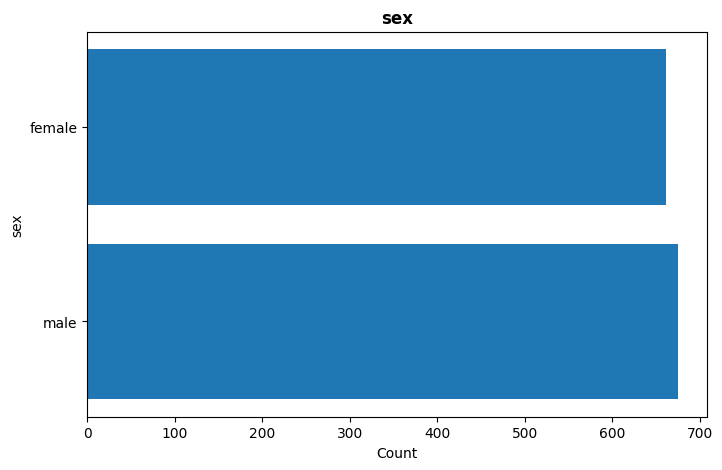

male      675
female    662
Name: sex, dtype: int64


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_list` loads all data into the driver's memory. It should only be used if the resulting list is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/generic.py:647: UserWarning: We recommend using `Series.to_numpy()` instead.
  warnings.warn("We recommend using `{}.to_numpy()` instead.".format(type(self).__name__))
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


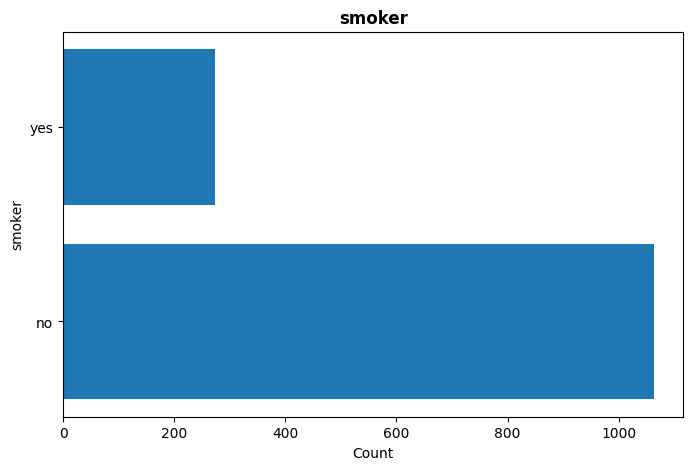

no     1063
yes     274
Name: smoker, dtype: int64


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_list` loads all data into the driver's memory. It should only be used if the resulting list is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/generic.py:647: UserWarning: We recommend using `Series.to_numpy()` instead.
  warnings.warn("We recommend using `{}.to_numpy()` instead.".format(type(self).__name__))
/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


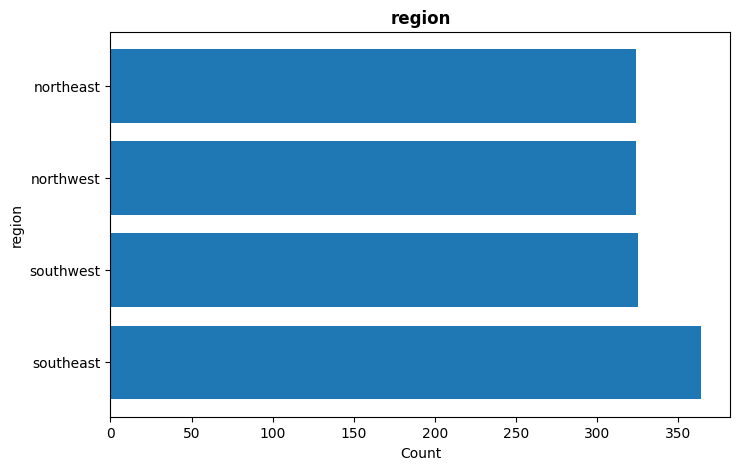

southeast    364
southwest    325
northwest    324
northeast    324
Name: region, dtype: int64


In [12]:
charts_eda_categorical(categorical_data)

Conclusions:
- **sex** column → The female/male ratio of insurance contractors is approximately 50/50.
- **smoker** column → The vast majority of insurance policyholders are non-smokers, approximately 80%.
- **region** column → Seem very close in numbers, especially between southwest, northwest, and northeast. In a real-world dataset, such close numbers can occur, but they might raise a suspicion of artificial manipulation or a perfectly balanced sampling process.

### 2.5. EDA Numerical Data

In [13]:
def statistics_cont(num):
    #use describe method transposed
    statistics = num.describe().T
    #Add the median
    statistics['median'] = num.median()
    # rearrange so that the median is next to the mean.
    statistics = statistics.iloc[:, [0, 1, 8, 2, 3, 4, 5, 6, 7]]
    return(statistics)



def charts_eda_numerical(numeric, bin):
    """
    Plots histograms for all numerical columns in the provided DataFrame.

    Parameters:
    numeric (pd.DataFrame): DataFrame containing only numerical columns.
    """
    # Define the number of bins for the histograms
    bins = bin

    # Create subplots
    num_cols = len(numeric.columns)
    nrows = (num_cols + 1) // 2
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(10, 4 * nrows))
    axes = axes.flatten()

    for i, col in enumerate(numeric.columns):
        axes[i].hist(numeric[col], bins=bins, color='skyblue', edgecolor='black')
        axes[i].set_title(f'{col} Distribution')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')

    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [14]:
statistics_cont(numerical_data)

,count,mean,median,std,min,25%,50%,75%,max
age,1337.0,39.222139,39.0000,14.044333,18.0000,27.000,39.0000,51.00000,64.00000
bmi,1337.0,30.663452,30.4000,6.100468,15.9600,26.290,30.4000,34.70000,53.13000
charges,1337.0,13279.121487,9386.1613,12110.359656,1121.8739,4746.344,9386.1613,16657.71745,63770.42801
children,1337.0,1.095737,1.0000,1.205571,0.0000,0.000,1.0000,2.00000,5.00000


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


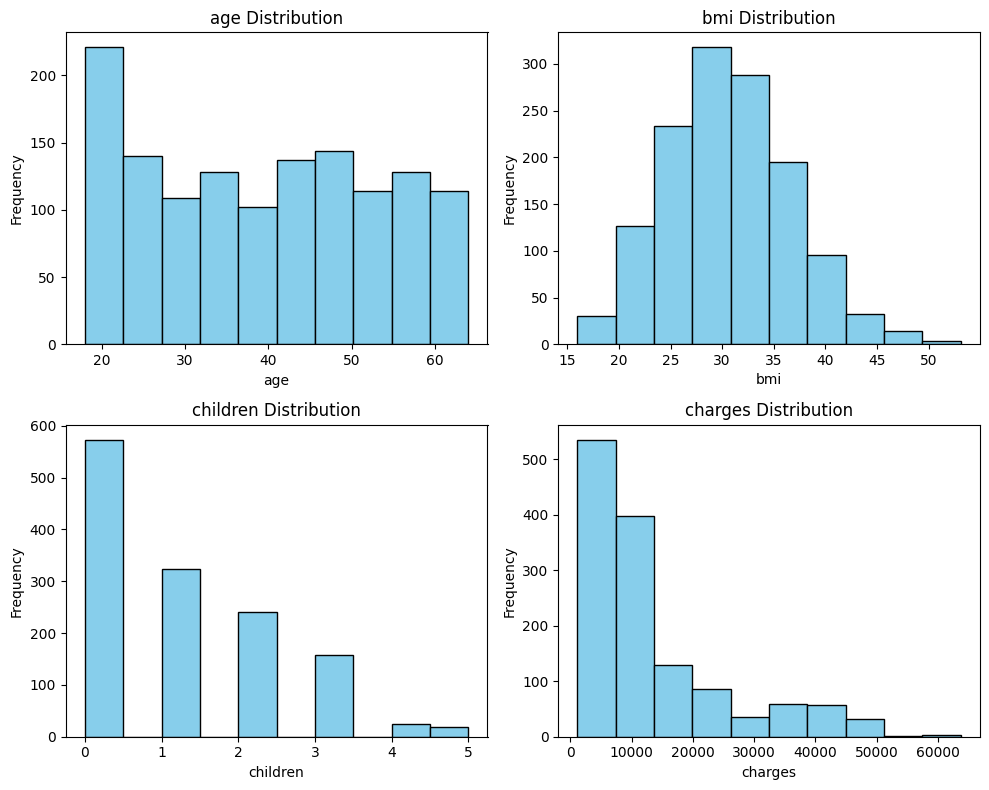

In [15]:
charts_eda_numerical(numerical_data, 10)

Conclusions:
- The insurance policyholders have an age range between [18, 64] with an average of approximately 39 years. This seems quite reasonable data for a insurance policyholders.

- The distribution of the BMI data is close to a "Normal Distribution". The average Body Mass Index in this dataset is approximately 30. However a normal BMI due to World Health Organization (WHO) is [18.5, 24.9]. These data and their distribution make sense in the real world, they appear to be correct.

- The average insurance policyholder has one child, however the mode is not to have children. Aditionally, the range is [0, 5] childs. This seems quite reasonable data.


- The distribution of the charges has a positive skewness.  It makes sense in an insurance context:  small number of policyholders might incur extremely high costs due to severe health conditions or accidents,  which leads to a positive skew in the charges distribution.


### 2.6. Insights generation

##### 2.6.1. What are the company's annual charges? What are the overall average charges for the company?

In [16]:
print("Total charges:", df.charges.sum())
print("Average charges:", df.charges.mean())

Total charges: 17754185.427659
Average charges: 13279.121486655948


#### 2.6.2. Do men or women pay more for insurance?



In [17]:
temp = df.groupby("sex")["charges"].mean().sort_values(ascending=False)
temp.plot.bar()

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/groupby.py:649: FutureWarning: Default value of `numeric_only` will be changed to `False` instead of `True` in 4.0.0.
  warnings.warn(


#### 2.6.3. Do smokers pay more for insurance compared to non-smokers?

In [18]:
temp = df.groupby("smoker")["charges"].mean().sort_values(ascending=False)
temp.plot.bar()

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/groupby.py:649: FutureWarning:

Default value of `numeric_only` will be changed to `False` instead of `True` in 4.0.0.



#### 2.6.4. How does BMI relate to the insurance charge?

In [19]:
# Define function to categorize BMI
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'underweight'
    elif 18.5 <= bmi < 25:
        return 'normal bodyweight'
    elif 25 <= bmi < 30:
        return 'overweight'
    elif 30 <= bmi < 35:
        return 'obese'
    else:
        return 'extreme obese'

In [20]:
df["cat_bmi"] = df["bmi"].apply(categorize_bmi)

temp = df.groupby("cat_bmi")["charges"].mean().sort_values(ascending=False)
temp.plot.bar()

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/groupby.py:649: FutureWarning:

Default value of `numeric_only` will be changed to `False` instead of `True` in 4.0.0.



#### 2.6.5. Do the BMI affects the charge the same way in smokers and non smokers?

In [21]:
# Filter the DataFrame for smokers and non-smokers
smokers = df[df['smoker'] == 'yes']
non_smokers = df[df['smoker'] == 'no']

# Group by bmi_categorical and compute the mean charges for smokers and non-smokers
smokers_mean_charges = smokers.groupby('cat_bmi')['charges'].mean().sort_values(ascending=False)
non_smokers_mean_charges = non_smokers.groupby('cat_bmi')['charges'].mean().sort_values(ascending=False)

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/groupby.py:649: FutureWarning:

Default value of `numeric_only` will be changed to `False` instead of `True` in 4.0.0.



/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas Series is expected to be small.

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas Series is expected to be small.



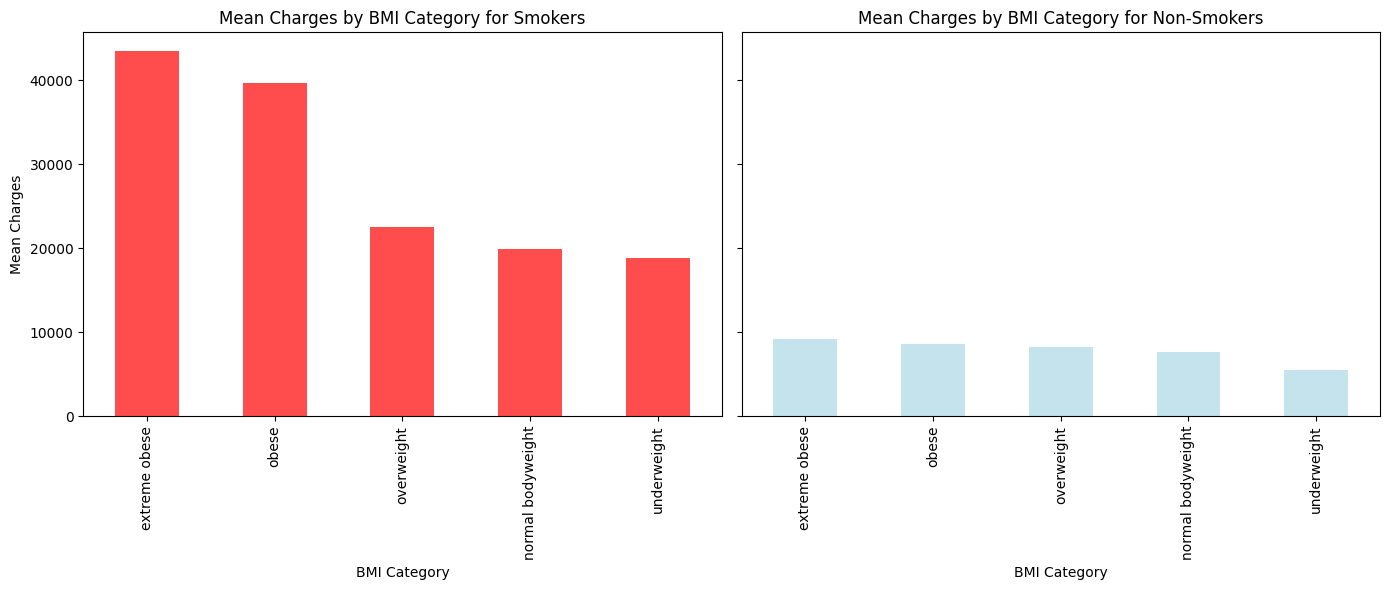

In [22]:
# Convert to Pandas DataFrame
smokers_mean_charges_pd = smokers_mean_charges.to_pandas()
non_smokers_mean_charges_pd = non_smokers_mean_charges.to_pandas()

# Plot the results
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot for smokers
smokers_mean_charges_pd.plot(kind='bar', ax=axes[0], color='red', alpha=0.7, title='Mean Charges by BMI Category for Smokers')
axes[0].set_xlabel('BMI Category')
axes[0].set_ylabel('Mean Charges')

# Plot for non-smokers
non_smokers_mean_charges_pd.plot(kind='bar', ax=axes[1], color='lightblue', alpha=0.7, title='Mean Charges by BMI Category for Non-Smokers')
axes[1].set_xlabel('BMI Category')

plt.tight_layout()
plt.show()

## 3. Machine Learning

### 3.1. Preprocessing

The algorithm that I will use for ML is Linear Regression. This algorith can handle binary categorical variables. For this reason I will not do OneHotEncoding for the binary columns. My approach will be the next:
- **sex** → Categorical to Numerical Data (0→female, 1→male)
- **smoker** → Categorical to Numerical Data (0→no, 1→yes)
- **region** → OneHotEncoding→expand unique values as columns
- **cat_bmi** → drop the column

In [23]:
# make a copy of the data for ML
df_ml = df.copy()

In [24]:
# Transform Categorical "sex" to Numerical
df_ml["sex"] = df_ml["sex"].map({"female": int(0), "male": int(1)}).astype(int)

# Transform Categorical "smoker" to Numerical
df_ml["smoker"] = df_ml["smoker"].map({"no": int(0), "yes": int(1)}).astype(int)

In [25]:
# OheHotEncoding → Transform Nominal Data to Numeric Data, expand unique values as columns
df_ml = df_ml.to_pandas()

ohe = OneHotEncoder(sparse_output=False).set_output(transform="pandas")

ohe_transform = ohe.fit_transform(df_ml[["region"]])

df_ml = pd.concat([df_ml, ohe_transform], axis=1).drop(columns=["region", "cat_bmi"])

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.



In [26]:
print(df_ml.info())
df_ml.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1337 non-null   int32  
 1   sex               1337 non-null   int64  
 2   bmi               1337 non-null   float64
 3   children          1337 non-null   int32  
 4   smoker            1337 non-null   int64  
 5   charges           1337 non-null   float64
 6   region_northeast  1337 non-null   float64
 7   region_northwest  1337 non-null   float64
 8   region_southeast  1337 non-null   float64
 9   region_southwest  1337 non-null   float64
dtypes: float64(6), int32(2), int64(2)
memory usage: 104.5 KB
None


,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0.0,0.0,0.0,1.0
1,18,1,33.770,1,0,1725.55230,0.0,0.0,1.0,0.0
2,28,1,33.000,3,0,4449.46200,0.0,0.0,1.0,0.0
3,33,1,22.705,0,0,21984.47061,0.0,1.0,0.0,0.0
4,32,1,28.880,0,0,3866.85520,0.0,1.0,0.0,0.0


### 3.3. Modeling with PySpark

In [27]:
# Convert pandas DataFrame to PySpark DataFrame
spark_df = spark.createDataFrame(df_ml)
spark_df.printSchema()

root
 |-- age: long (nullable = true)
 |-- sex: long (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: long (nullable = true)
 |-- smoker: long (nullable = true)
 |-- charges: double (nullable = true)
 |-- region_northeast: double (nullable = true)
 |-- region_northwest: double (nullable = true)
 |-- region_southeast: double (nullable = true)
 |-- region_southwest: double (nullable = true)



### 3.1. Scaling the Data

In linear regression, the coefficients (weights) associated with features indicate their importance. If features are on different scales, the model might incorrectly assign importance to the features with larger scales.

All the features are binary (0-1), except "age" and "bmi". I scale the "age" feature before assembling it with the other features.

In [28]:
# Assemble the features into a single vector column for age and bmi
assembler_age = VectorAssembler(inputCols=["age"], outputCol="age_vector")
assembler_bmi = VectorAssembler(inputCols=["bmi"], outputCol="bmi_vector")

# Transform the data
age_vector_data = assembler_age.transform(spark_df)
bmi_vector_data = assembler_bmi.transform(age_vector_data)

# Scale the "age" feature
scaler_age = StandardScaler(inputCol="age_vector", outputCol="scaled_age", withStd=True, withMean=True)
scaler_model_age = scaler_age.fit(bmi_vector_data)
scaled_age_data = scaler_model_age.transform(bmi_vector_data)

# Scale the "bmi" feature
scaler_bmi = StandardScaler(inputCol="bmi_vector", outputCol="scaled_bmi", withStd=True, withMean=True)
scaler_model_bmi = scaler_bmi.fit(scaled_age_data)
scaled_bmi_data = scaler_model_bmi.transform(scaled_age_data)

# Drop the original 'age' and 'bmi' columns and keep the 'scaled_age' and 'scaled_bmi'
scaled_spark_df = scaled_bmi_data.drop('age', 'bmi').withColumnRenamed('scaled_age', 'age').withColumnRenamed('scaled_bmi', 'bmi')

In [29]:
scaled_spark_df.show()

+---+--------+------+-----------+----------------+----------------+----------------+----------------+----------+----------+--------------------+--------------------+
|sex|children|smoker|    charges|region_northeast|region_northwest|region_southeast|region_southwest|age_vector|bmi_vector|                 age|                 bmi|
+---+--------+------+-----------+----------------+----------------+----------------+----------------+----------+----------+--------------------+--------------------+
|  0|       0|     1|  16884.924|             0.0|             0.0|             0.0|             1.0|    [19.0]|    [27.9]|[-1.439878953326557]|[-0.4529900938935...|
|  1|       1|     0|  1725.5523|             0.0|             0.0|             1.0|             0.0|    [18.0]|   [33.77]|[-1.511082051325507]|[0.5092311005884274]|
|  1|       3|     0|   4449.462|             0.0|             0.0|             1.0|             0.0|    [28.0]|    [33.0]|[-0.7990510713360...|[0.3830112846171983]|
|  1

### 3.2. Select features and target values

In [30]:
# Assemble all the features into a single vector column
feature_columns = [col for col in scaled_spark_df.columns if col not in ['charges', 'age_vector', 'bmi_vector']]
assembler_final = VectorAssembler(inputCols=['age', 'bmi'] + feature_columns, outputCol='features')
data_ml = assembler_final.transform(scaled_spark_df)

In [31]:
# Select the final features and target
data_ml = data_ml.select('features', 'charges')

### 3.3. Split into Training/Test Data

In [32]:
# Split the data into training and testing sets
train_data, test_data = data_ml.randomSplit([0.7, 0.3], seed=23)

print("Training Dataset Count: " + str(train_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 939
Test Dataset Count: 398


### 3.4. Iniciate the model

In [33]:
# Initialize the linear regression model
lr = LinearRegression(featuresCol='features', labelCol='charges')

### 3.5. Train the model

In [34]:
lr_model = lr.fit(train_data)

### 3.6. Predictions

In [35]:
# Make predictions on the test data
test_results = lr_model.evaluate(test_data)

### 3.7. Evaluate the model

**Mean Squared Error**

$ \text{MSE}(y, \hat{y}) = \frac{1}{n} \Sigma_{i=1}^n({y}-\hat{y})^2$

This statistic quantifies the average squared variance between observed and predicted values. When there are no errors in a model, the MSE equals 0. MSE is used for regression if it is considered to be normally distributed and wish to punish big mistakes more than little ones.


**Root Mean Squared Error**

$\text{RMSE}(y, \hat{y}) = \sqrt{\frac{\sum_{i=0}^{n - 1} (y_i - \hat{y}_i)^2}{N}}$

Root Mean Square Error (RMSE) is a statistical measure that is often used to evaluate the accuracy of a forecasting model. The RMSE is a widely used measure of forecast accuracy because it is sensitive to both the magnitude and direction of the errors. A lower RMSE indicates better forecast accuracy. However, it has a drawback that it is not normalized, meaning that it is dependent on the scale of the response variable.


**R-squared**

$R^2$ = 1 - $\frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2}$

The R-squared metric — R², or the coefficient of determination is a statistical measure in a regression model that determines the proportion of variance in the dependent variable that can be explained by the independent variable. R-squared can take any values between 0 to 1. An R² of 1 indicates that the regression model perfectly fits the data. An R² of 0 indicates that the model does not explain any of the variability of the response data around its mean.  For example, an R² of 0.7 means that 70% of the variance in the dependent variable is explained by the independent variables in the model.



In [36]:
MSE_base = test_results.meanSquaredError
RMSE_base = test_results.rootMeanSquaredError
r2_base = test_results.r2

print(f"MSE: {MSE_base}")
print(f"RMSE: {RMSE_base}")
print(f"R^2: {r2_base}")

MSE: 43384518.99885235
RMSE: 6586.692569025243
R^2: 0.721379532584387


Conclusions:

Based on the provided metrics, the model has captured a significant portion of the variance in the insurance charges but still has a notable prediction error. Specially:
- The R² value of approximately 0.721 indicates that 72.1% of the variance in insurance charges is explained by the model, suggesting it is fairly robust but not perfect.
- The RMSE of approximately 6586.69 indicates a substantial average prediction error.

Given my analysis in the point 2.5. EDA Numerical Data, it is not uncommon to expect such results. In the EDA:
- A range [4746.34, 63770.42]
- A arithmetic mean  → mean=13279
- A standard deviation std→ =12110.35
- The RMSE is almost 1.8 times less than the standard deviation, which means the model's error is reasonably low compared to the overall spread of the charges data. This suggests that while the model's predictions have some error, it is performing relatively well considering the inherent variability in the data.

To sum up, there is potential for improvement.


### 3.8. Improving the model

#### 3.8.1. Logaritmic Transformation

 This transformation could provide some benefits for a Linear Regression model:
  * Symmetry: Transforming the target variable (e.g., using a log transformation) can make its distribution more symmetric.
  * Error Distribution: This can help in meeting the normality assumption of residuals, potentially leading to better model performance.
  * Prediction Quality: It can improve the prediction quality, making the model more robust in predicting both low and high charges.

In [37]:
# Convert PySpark DataFrame to Pandas DataFrame
data_ml_pandas = data_ml.toPandas()

# Apply the logarithmic transformation to the "charges" column
data_ml_pandas['log_charges'] = np.log(data_ml_pandas["charges"])

# Drop the original "charges" column
data_ml_pandas = data_ml_pandas.drop(columns=["charges"])

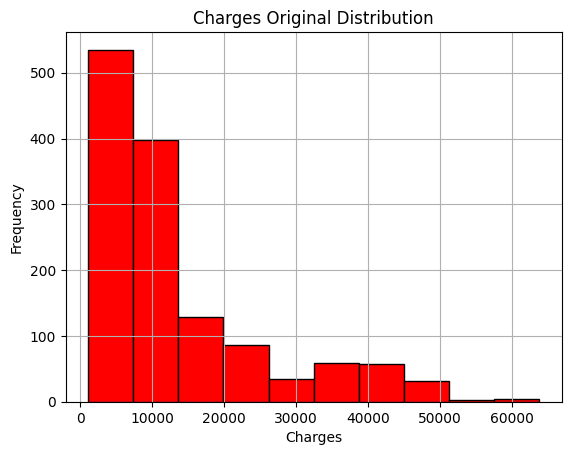

In [38]:
# BEFORE TRANSFORMATION
df_ml.charges.hist(bins=10, color='red', edgecolor='black', )
plt.title("Charges Original Distribution")
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.show()

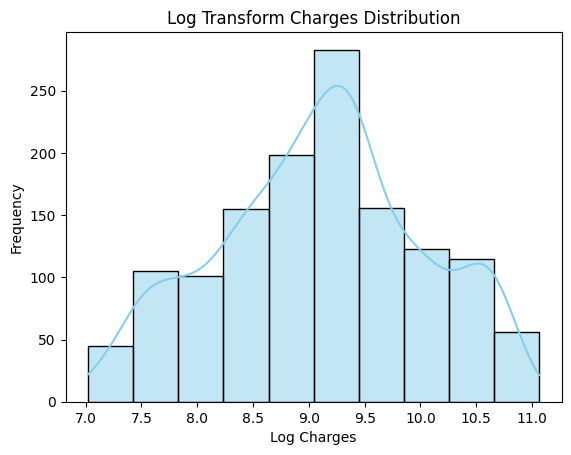

In [39]:
sns.histplot(data_ml_pandas['log_charges'], bins=10, kde=True, color='skyblue', edgecolor='black')
plt.title("Log Transform Charges Distribution")
plt.xlabel('Log Charges')
plt.ylabel('Frequency')
plt.show()

In [40]:
# Convert the Pandas DataFrame back to a PySpark DataFrame
data_ml = spark.createDataFrame(data_ml_pandas)

# Select the final features and transformed target
data_ml = data_ml.select('features', 'log_charges')

# Rename 'log_charges' to 'charges' to use in the model
data_ml = data_ml.withColumnRenamed('log_charges', 'charges')

In [41]:
# Split the data into training and testing sets
train_data, test_data = data_ml.randomSplit([0.7, 0.3], seed=23)

print("Training Dataset Count: " + str(train_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 939
Test Dataset Count: 398


In [42]:
# Initialize the optimized linear regression model
lr_optimized = LinearRegression(featuresCol='features', labelCol='charges')

In [43]:
# train the optimized linear regression model
lr_optimized_model = lr_optimized.fit(train_data)

In [44]:
# Make predictions on the test data
test_results_optimized = lr_optimized_model.evaluate(test_data)

In [45]:
# Evaluate the optimized model
MSE_optimized = test_results_optimized.meanSquaredError
RMSE_optimized = test_results_optimized.rootMeanSquaredError
r2_optimized = test_results_optimized.r2

print(f"R^2: {r2_base}")
print(f"R^2 optimized: {r2_optimized}")

R^2: 0.721379532584387
R^2 optimized: 0.7464831186530758


Conclusion:

The improvement in the $R^2$ metric after applying the **logarithmic transformation** suggests that the transformation has made the relationship between the features and the target variable more linear and predictable, leading to **better model performance**.


#### 3.8.2. Hyperparameter Tuning

In [46]:
# Set up the evaluator
evaluator = RegressionEvaluator(labelCol="charges", predictionCol="prediction", metricName="r2")

In [47]:
# Define a parameter grid for hyperparameter tuning
param_grid = (ParamGridBuilder()
              .addGrid(lr_optimized.regParam, [0.01, 0.01, 0.1, 0.5, 0.7])
              .addGrid(lr_optimized.elasticNetParam, [0.0, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 0.7, 1.0])
              .addGrid(lr_optimized.maxIter, [5, 10, 25, 50, 75, 100, 150, 200])
              .build())

# Set up CrossValidator
crossval = CrossValidator(estimator=lr_optimized,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=5)

# Run cross-validation and choose the best set of parameters
cv_model = crossval.fit(train_data)

In [48]:
# Make predictions on the test data using the best model
best_model = cv_model.bestModel
test_results_optimized = best_model.evaluate(test_data)

In [49]:
# Evaluate the optimized model
MSE_optimized = test_results_optimized.meanSquaredError
RMSE_optimized = test_results_optimized.rootMeanSquaredError
r2_optimized = test_results_optimized.r2

print(f"R^2: {r2_base}")
print(f"R^2 optimized: {r2_optimized}")

R^2: 0.721379532584387
R^2 optimized: 0.7476102490886976


Conclusion:

Lack of improvement after hyperparameter tuning might be due to various factors such as data split, model complexity, or data size. For example, this dataset is small and with smaller datasets hyperparameter tuning may not show significant improvements due to limited data for training and validation.

Apart from scaling and transformation, some consideration is **feature engineering** for model improving.

#### 3.8.3. Feature Engineering

In [66]:
df_ml2 = df_ml.copy()
df_ml2.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0.0,0.0,0.0,1.0
1,18,1,33.770,1,0,1725.55230,0.0,0.0,1.0,0.0
2,28,1,33.000,3,0,4449.46200,0.0,0.0,1.0,0.0
3,33,1,22.705,0,0,21984.47061,0.0,1.0,0.0,0.0
4,32,1,28.880,0,0,3866.85520,0.0,1.0,0.0,0.0


I will try with a different approach and I am going to do feature engineering. So the steps to follow are:
1. Feature Engineering → bmi, age and children
2. One Hot Encoding
3. Logaritmic Transformation to charges
4. ML Model
5. Tunning the Model

##### 1. Feature Engineering

In [67]:
# Feature Engineering → add cat_bmi column and drop bmi column
df_ml2["cat_bmi"] = df_ml2["bmi"].apply(categorize_bmi)
df_ml2 = df_ml2.drop(columns=["bmi"])

In [68]:
#FEATURE ENGINEERING → Binning Age
def bin_age(age):
    if age < 18:
        return 'under_18'
    elif 18 <= age < 30:
        return '18_29'
    elif 30 <= age < 50:
        return '30_49'
    else:
        return '50_plus'

#FEATURE ENGINEERING → Binning Children
def bin_children(children):
    if children == 0:
        return 'no_children'
    elif 1 <= children <= 3:
        return '1_3_children'
    else:
        return 'more_than_3_children'

In [69]:
# Feature Engineering → add "age_bin" column and drop "age" column
df_ml2["age_bin"] = df_ml2["age"].apply(bin_age)
df_ml2 = df_ml2.drop(columns=["age"])

# Feature Engineering → add "children_bin" column and drop "children" column
df_ml2["children_bin"] = df_ml2["children"].apply(bin_children)
df_ml2 = df_ml2.drop(columns=["children"])

##### 2. One Hot Encoding

In [72]:
# One-Hot Encoding for remaining categorical variables
# One-Hot Encoding for remaining categorical variables
df_ml2 = pd.get_dummies(df_ml2, columns=["age_bin", "children_bin", "cat_bmi"], drop_first=True)

# Ensure all dummy columns are integer type
for col in df_ml2.columns:
    if df_ml2[col].dtype == bool:
        df_ml2[col] = df_ml2[col].astype(int)

##### 3. Logarithmic Transformation

In [75]:
# Apply the logarithmic transformation to the "charges" column
df_ml2["log_charges"] = np.log(df_ml2["charges"])

# Drop the original "charges" column
df_ml2 = df_ml2.drop(columns=["charges"])

In [82]:
# change type from int to float to unificate criteria
df_ml2["region_northeast"] = df_ml2["region_northeast"].astype("int64")
df_ml2["region_northwest"] = df_ml2["region_northwest"].astype("int64")
df_ml2["region_southeast"] = df_ml2["region_southeast"].astype("int64")
df_ml2["region_southwest"] = df_ml2["region_southwest"].astype("int64")

# Check the transformed dataframe
print(df_ml2.info())
df_ml2.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   sex                                1337 non-null   int64  
 1   smoker                             1337 non-null   int64  
 2   region_northeast                   1337 non-null   int64  
 3   region_northwest                   1337 non-null   int64  
 4   region_southeast                   1337 non-null   int64  
 5   region_southwest                   1337 non-null   int64  
 6   age_bin_30_49                      1337 non-null   int64  
 7   age_bin_50_plus                    1337 non-null   int64  
 8   children_bin_more_than_3_children  1337 non-null   int64  
 9   children_bin_no_children           1337 non-null   int64  
 10  cat_bmi_normal bodyweight          1337 non-null   int64  
 11  cat_bmi_obese                      1337 non-null   int64  
 1

,sex,smoker,region_northeast,region_northwest,region_southeast,region_southwest,age_bin_30_49,age_bin_50_plus,children_bin_more_than_3_children,children_bin_no_children,cat_bmi_normal bodyweight,cat_bmi_obese,cat_bmi_overweight,cat_bmi_underweight,log_charges
0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,9.734176
1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,7.453302
2,1,0,0,0,1,0,0,0,0,0,0,1,0,0,8.400538
3,1,0,0,1,0,0,1,0,0,1,1,0,0,0,9.998092
4,1,0,0,1,0,0,1,0,0,1,0,0,1,0,8.260197


##### Machine Learning with PySpark

In [84]:
# Convert the Pandas DataFrame to a PySpark DataFrame
df_ml2 = spark.createDataFrame(df_ml2)

# Split the data into training and testing sets
train_data, test_data = df_ml2.randomSplit([0.7, 0.3], seed=23)

print("Training Dataset Count: " + str(train_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 939
Test Dataset Count: 398


In [85]:
# Assemble the features into a single vector column
feature_columns = [col for col in df_ml2.columns if col != 'log_charges']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

# Select the final features and transformed target
train_data = train_data.select('features', 'log_charges')
test_data = test_data.select('features', 'log_charges')

# Rename 'log_charges' to 'charges' to use in the model
train_data = train_data.withColumnRenamed('log_charges', 'charges')
test_data = test_data.withColumnRenamed('log_charges', 'charges')

In [86]:
# Initialize the linear regression model
lr = LinearRegression(featuresCol='features', labelCol='charges')

# Define a parameter grid for hyperparameter tuning
param_grid = (ParamGridBuilder()
              .addGrid(lr.regParam, [0.01, 0.1, 0.5, 0.7])
              .addGrid(lr.elasticNetParam, [0.0, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 0.7, 1.0])
              .addGrid(lr.maxIter, [5, 10, 25, 50, 75, 100, 150, 200])
              .build())

# Set up CrossValidator
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=param_grid,
                          evaluator=RegressionEvaluator(labelCol="charges", predictionCol="prediction", metricName="r2"),
                          numFolds=5)

In [87]:
# Run cross-validation and choose the best set of parameters
cv_model_eing = crossval.fit(train_data)

In [90]:
# Make predictions on the test data using the best model
best_model_eng = cv_model_eing.bestModel
test_results_optimized_eing = best_model_eng.evaluate(test_data)

In [91]:
# Evaluate the optimized model + Feature Engineering
MSE_optimized_eng = test_results_optimized_eing.meanSquaredError
RMSE_optimized_eng = test_results_optimized_eing.rootMeanSquaredError
r2_optimized_eng = test_results_optimized_eing.r2

In [92]:
print(f"R^2: {r2_base}")
print(f"R^2 optimized: {r2_optimized}")
print(f"Optimized R^2 + Feature Engineering: {r2_optimized_eng}")

R^2: 0.721379532584387
R^2 optimized: 0.7476102490886976
Optimized R^2 + Feature Engineering: 0.7494524842680276


**Conclusions**

After performing the necessary steps of data preprocessing, feature engineering, and model optimization using PySpark, I observed the following results:
1. **Base Model**: The initial model provided a baseline $R^2$ of 0.7214. This indicates that the model explains approximately 72.14% of the variance in the target variable (charges).
2. **Log Transformation**: Applying a logarithmic transformation to the target variable improved the model's $R^2$ to 0.7464. This transformation helps to stabilize the variance and make the target variable distribution more normal, which generally enhances linear regression model performance.
3. **Feature Engineering and Hyperparameter Tuning**: Further feature engineering (such as binning age and children, categorizing BMI) combined with hyperparameter tuning improved the model slightly more, reaching an R^2 of 0.7495. These steps help in capturing more nuanced relationships between the features and the target variable, and tuning the hyperparameters allows for finding the best configuration of the model parameters.

In summary, the process of data preprocessing, feature engineering, and model optimization significantly improved the model performance from an $R^2$ of 0.7214 to 0.7495. This iterative process of refining the model highlights the importance of each step in the machine learning workflow.